### Analyze Data Drift on Employee Attrition Data

* Author: L. Saetta
* first version: 20/06/2022
* updated:       21/06/2002

I have developed a function (see end of Notebook) that can be used to compare two (reference, new) datasets to see if there is a **Data Drift**
* for numerical features: **Kolmogorov - Smirnov** test
* for categorical features: **Chi2 test on contingency table**

To show drift, I have used Employee Attrition data, split in two dataset and made some manual changes in order to "create" drift

* to be used, dataset must entirely fit in memory in a Pandas DF (eventually make good usage of data types when read, for ex. from csv, to reduce memory footprint

Summary of changes:
* (21/06/2022): describe on dataset only once
* (21/06/2022) added computation of wasserstein distance for numerical 
* (21/06/2022): added selection of features (see exclusion list)
* added mean difference for numerical
* (21/06/2022): refactored code, introduced drift_analysis.py
* (22/06/2022): tested with ADS 2.5.10
* (222/06/2022): moved functions for plotting to drift_analysis.py

In [1]:
import pandas as pd
import numpy as np
import ads

from sklearn.model_selection import train_test_split

# all the functions with the core of the code have been moved there
from drift_analysis import *

import logging
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

%matplotlib inline

In [2]:
print(ads.__version__)

2.5.10


In [3]:
# if you want to recreate csv
# !rm *.csv

In [4]:
#
# All the functions for plotting moved to data_attrition.py
# 
TARGET = "Attrition"

### Read Attrition Dataset from file

In [5]:
attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

df = pd.read_csv(attrition_path)

In [6]:
# we don't need these columns (are constant)

cols_to_drop = ['Directs','name', 'Over18','WeeklyWorkedHours','EmployeeNumber']

df_used = df.drop(columns=cols_to_drop)

In [7]:
TARGET = 'Attrition'

features = list(set(df_used.columns) - set([TARGET]))

print("The list of features:")
features

The list of features:


['HourlyRate',
 'Age',
 'TravelForWork',
 'CommuteLength',
 'SalaryLevel',
 'MonthlyRate',
 'YearsWithCurrManager',
 'WorkLifeBalance',
 'EnvironmentSatisfaction',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'YearsinIndustry',
 'JobInvolvement',
 'MonthlyIncome',
 'YearsSinceLastPromotion',
 'EducationField',
 'JobRole',
 'YearsOnJob',
 'JobLevel',
 'OverTime',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'JobFunction',
 'MaritalStatus',
 'PerformanceRating',
 'TrainingTimesLastYear',
 'EducationalLevel',
 'JobSatisfaction',
 'YearsAtCurrentLevel',
 'Gender']

### Create two datasets from the same populations and save to files

In [8]:
# train, test split
dfx_train, dfx_test= train_test_split(df_used[features], shuffle=True, test_size=0.2, random_state = 1234)

print("# of samples in train set", dfx_train.shape[0])
print("# of samples in test set", dfx_test.shape[0])

# of samples in train set 1176
# of samples in test set 294


In [9]:
# salvo per creare i due dataset da confrontare
dfx_train.to_csv("reference.csv", index=None)
dfx_test.to_csv("current.csv", index=None)

### Start from the two saved files

In [10]:
# ripartiamo dai file: rileggiamoli (è un restart point)

df_set1 = pd.read_csv("reference.csv")
df_set2 = pd.read_csv("current.csv")
# se leggo solo i file devo rieseeguire:

categorical_columns = identify_categorical(df_set1, exc_list=[TARGET])
# all the rest
numerical_columns = list(set(df_set1.columns) - set(categorical_columns) -set([TARGET]))

print("Dividing into Categorical and Continuous features:")
print()
print("Categorical columns:", categorical_columns)
print()
print("Numerical columns:", numerical_columns)

Dividing into Categorical and Continuous features:

Categorical columns: ['TravelForWork', 'WorkLifeBalance', 'EnvironmentSatisfaction', 'RelationshipSatisfaction', 'StockOptionLevel', 'JobInvolvement', 'EducationField', 'JobRole', 'JobLevel', 'JobSatisfaction', 'OverTime', 'JobFunction', 'MaritalStatus', 'PerformanceRating', 'TrainingTimesLastYear', 'EducationalLevel', 'Gender']

Numerical columns: ['HourlyRate', 'Age', 'CommuteLength', 'YearsOnJob', 'NumCompaniesWorked', 'PercentSalaryHike', 'YearsWithCurrManager', 'YearsinIndustry', 'MonthlyIncome', 'MonthlyRate', 'SalaryLevel', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion']


### Start analysis of Numerical Features

In [11]:
# invecchiamo Age di tot anni
SHIFT1 = 5
# Aumentiamo MonthlyIncome
SHIFT2 = 2000

#
# per cambiare le distribuzioni !!
#
df_set2['Age'] = df_set2['Age'] + SHIFT1
df_set2['MonthlyIncome'] = df_set2['MonthlyIncome'] + SHIFT2

In [12]:
#
# Test su numeriche
#
# using Kolmogorov-Smirnov test check if the data come from the same distribution


#
# la soglia usata nei test
#
P_THR = 0.01

for col in numerical_columns:
    # per prendere solo le numeriche
    
    stats, p_value = ks_2samp(df_set1[col].values, df_set2[col].values)
        
    if p_value < P_THR:
        print("Identified drift in column:", col)
        print(f"p_value: {round(p_value, 3)}")
        print()

Identified drift in column: Age
p_value: 0.0

Identified drift in column: MonthlyIncome
p_value: 0.0



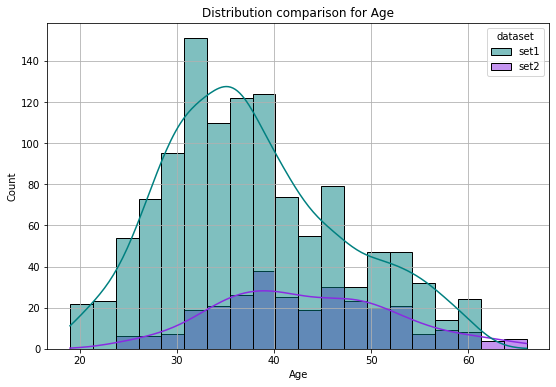

In [13]:
# let's visualize the distributions
plot_comparison_numeric(df_set1, df_set2, 'Age')

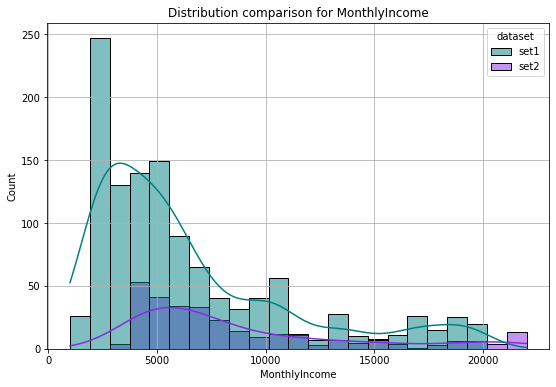

In [14]:
plot_comparison_numeric(df_set1, df_set2, 'MonthlyIncome')

### Then, Categorical Features

In [15]:
# create a shift

COL = 'MaritalStatus'

#
# alteriamo set2
#
condition = (df_set2[COL] == 'Single')
df_set2.loc[condition, COL] = 'Married'

In [16]:
#
# facciamo il test CHi2 sulla contingency table
#

for col in categorical_columns:
    c_table, index = compute_contingency_table(df_set1[col], df_set2[col])

    statistic, p_value, dof, _ = chi2_contingency(c_table)

    if p_value < P_THR:
        print("Identified drift in column:", col)
        print(f"p_value: {round(p_value, 3)}")
        print()
        print("Comparison of occurrencies:")
        print("Reference set:", c_table[0,0,:])
        print("New set:", c_table[1,0,:])
        print(f"Index: {index}")
        print()

Identified drift in column: MaritalStatus
p_value: 0.0

Comparison of occurrencies:
Reference set: [267. 380. 529.]
New set: [ 60.   0. 234.]
Index: ['Divorced', 'Single', 'Married']



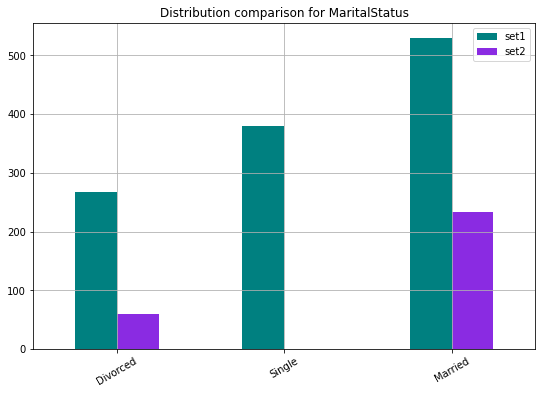

In [17]:
plot_comparison_categorical1(df_set1, df_set2, 'MaritalStatus')

### Let's automate everything

* we pass as input two DataFrame and get as a result a report that signals is there is some significant change

In [18]:
# the function identify_data_drift is in drift_analysis.py

In [19]:
# to use it read the file as Pandas DataFrame and pass the df
df_set1 = pd.read_csv("reference.csv")
df_set2 = pd.read_csv("current.csv")

# simulate some changes (to remove with real files)
df_set2['Age'] = df_set2['Age'] + 2
df_set2['MonthlyIncome'] = df_set2['MonthlyIncome'] + 1000
# salary level has large variance... therefore to create drift we need a rather big change
df_set2['SalaryLevel'] = df_set2['SalaryLevel'] + 800

condition = (df_set2['MaritalStatus'] == 'Single')
df_set2.loc[condition, 'MaritalStatus'] = 'Married'


# check same number of columns
assert df_set1.shape[1] == df_set2.shape[1]

# do_print=False: I want only the result dict, not printing
drifts = identify_data_drift(df_set1, df_set2, do_print=False, exc_list=["Attrition"])

In [20]:
# in stats: mean, std, min, perc, max for numerical see df.describe().T
# c_table for categorical
drifts

[{'Column': 'Age',
  'Type': 'continuous',
  'p_value': 0.00034,
  'threshold': 0.01,
  'stats': '[37.81, 9.17, 19.0, 31.0, 36.0, 43.25, 61.0],[40.36, 9.01, 21.0, 34.0, 39.0, 46.75, 63.0]',
  'was_distance_norm': 0.067,
  'delta_mean_norm': 0.067},
 {'Column': 'MaritalStatus',
  'Type': 'categorical',
  'p_value': 0.0,
  'threshold': 0.01,
  'stats': '[[[267. 380. 529.]]\n\n [[ 60.   0. 234.]]]'},
 {'Column': 'MonthlyIncome',
  'Type': 'continuous',
  'p_value': 0.0,
  'threshold': 0.01,
  'stats': '[6433.62, 4614.91, 1009.0, 2931.25, 4965.5, 8097.0, 19973.0],[7780.19, 5061.9, 2359.0, 3888.75, 5815.0, 9862.0, 20999.0]',
  'was_distance_norm': 0.209,
  'delta_mean_norm': 0.209},
 {'Column': 'SalaryLevel',
  'Type': 'continuous',
  'p_value': 0.00025,
  'threshold': 0.01,
  'stats': '[3703.16, 1850.47, 466.0, 2154.0, 3710.0, 5328.0, 6874.0],[4386.51, 1852.48, 1332.0, 2780.0, 4241.0, 6062.0, 7660.0]',
  'was_distance_norm': 0.185,
  'delta_mean_norm': 0.185}]

In [21]:
# if we want results as Pandas
result_df = pd.DataFrame(drifts)

print("*** Report on evidences of Data Drift identified ***")
print()
result_df.head()

*** Report on evidences of Data Drift identified ***



,Column,Type,p_value,threshold,stats,was_distance_norm,delta_mean_norm
0,Age,continuous,0.00034,0.01,"[37.81, 9.17, 19.0, 31.0, 36.0, 43.25, 61.0],[...",0.067,0.067
1,MaritalStatus,categorical,0.00000,0.01,[[[267. 380. 529.]]\n\n [[ 60. 0. 234.]]],NaN,NaN
2,MonthlyIncome,continuous,0.00000,0.01,"[6433.62, 4614.91, 1009.0, 2931.25, 4965.5, 80...",0.209,0.209
3,SalaryLevel,continuous,0.00025,0.01,"[3703.16, 1850.47, 466.0, 2154.0, 3710.0, 5328...",0.185,0.185


In [22]:
# in this example, since the two distribution differ for a shift (+ something)
# was and delta_mean are equal... but this is not always the case

### Save on file

In [23]:
# save the df_result on file (so, it can be moved to Object Storage)
from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d_%H:%M')

RESULT_FILE_NAME = f"drift_analysis_{now}.csv"

result_df.to_csv(RESULT_FILE_NAME)